# Group 5: Implementing Principal Component Analysis
  
### Authors 
- Hagen, Paula
- Huhle, Paul Moritz
- Int-Veen, Harpreet
- Kaviapoor Esfahani, Sepideh
- Kühnel, Paul (Group leader)
- Schuster, Karoline


### Outline
1. Load and prepare data
2. Investigate results with PCA libraries
    - pca
    - sklearn
    - statsmodels
3. Apply own PCA on data and compare with libraries
4. Use results for classification
5. Compare results with tSNE

In [2]:
### IMPORTS ###

# basics and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pca library methods
from pca import pca as pca_pca
from statsmodels.multivariate.pca import PCA as stm_pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as skl_pca

# for classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# own functions
from dataimport import get_df_merged_with_labels
from dataimport import random_sample, get_random_sample
from data_cleaning import preprocessing, drop_insignificant_data, center_data, standardize_data
from our_pca import our_pca, apply_components

   
## 1. Load and prepare data
In this section, we use our own functions from dataimport.py and data_cleaning.py. In the end, we will have a (labeled) test set and an (unlabeled) training set.

In [3]:
# get full data
df_labeled =  get_df_merged_with_labels()
print("Labeled Data: \n", df_labeled.head(10))

# Check if there aren't any missings
print("Number of missings: ", df_labeled.isnull().sum().sum())

# make unlabeled data frame
if 'Class' in df_labeled.columns:
    df_unlabeled = df_labeled.drop(['Class'], axis=1)

Labeled Data: 
   Class  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5    gene_6  \
0  PRAD     0.0  2.017209  3.265527  5.478487  10.431999     0.0  7.175175   
1  LUAD     0.0  0.592732  1.588421  7.586157   9.623011     0.0  6.816049   
2  PRAD     0.0  3.511759  4.327199  6.881787   9.870730     0.0  6.972130   
3  PRAD     0.0  3.663618  4.507649  6.659068  10.196184     0.0  7.843375   
4  BRCA     0.0  2.655741  2.821547  6.539454   9.738265     0.0  6.566967   
5  PRAD     0.0  3.467853  3.581918  6.620243   9.706829     0.0  7.758510   
6  KIRC     0.0  1.224966  1.691177  6.572007   9.640511     0.0  6.754888   
7  PRAD     0.0  2.854853  1.750478  7.226720   9.758691     0.0  5.952103   
8  BRCA     0.0  3.992125  2.772730  6.546692  10.488252     0.0  7.690222   
9  PRAD     0.0  3.642494  4.423558  6.849511   9.464466     0.0  7.947216   

     gene_7  gene_8  ...  gene_20521  gene_20522  gene_20523  gene_20524  \
0  0.591871     0.0  ...    4.926711    8.210257 

   
## 2. Investigate results with PCA libraries
In this section, we compare the PCA results for this data set obtained from three libraries:
- pca
- sklearn
- statsmodels

### Results with pca library

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [20531] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [478] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [20531] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[478]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 478 Principal Components explain [95.04%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

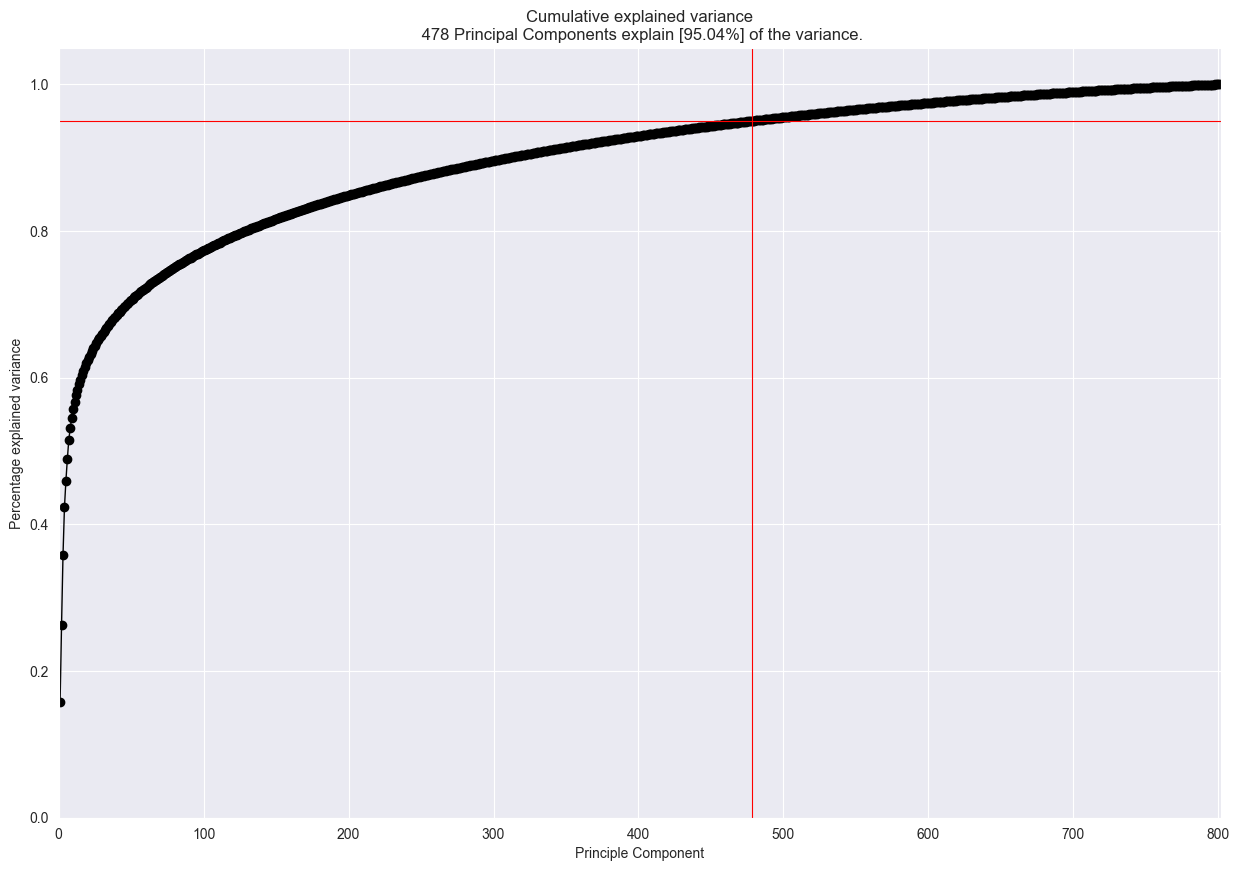

In [4]:
# Initialize pca from "pca" library with default parameters
model_pca_pca = pca_pca()
results_pca = model_pca_pca.fit_transform(center_data(df_unlabeled))

# Plot the explained variance (elbow plot)
model_pca_pca.plot()

### Results with sklearn library

In [5]:
# PCA with 2 components
skl_pca_2_components = skl_pca(n_components=2)

# apply components on data
data_on_2_components = pd.DataFrame(skl_pca_2_components.fit_transform(df_unlabeled))
data_on_2_components.columns = ['pca1','pca2']

# add cancer labels 
data_on_2_components['cancer_type'] = df_labeled['Class']
data_on_2_components

,pca1,pca2,cancer_type
0,-62.755415,-94.071973,PRAD
1,-2.432896,90.585842,LUAD
2,-71.266853,-8.064608,PRAD
3,-84.770785,-73.244566,PRAD
4,-69.560171,-9.612940,BRCA
...,...,...,...
796,-60.861882,-22.278633,BRCA
797,-14.465433,53.392194,LUAD
798,10.486261,21.570594,COAD
799,-55.063605,-92.394778,PRAD


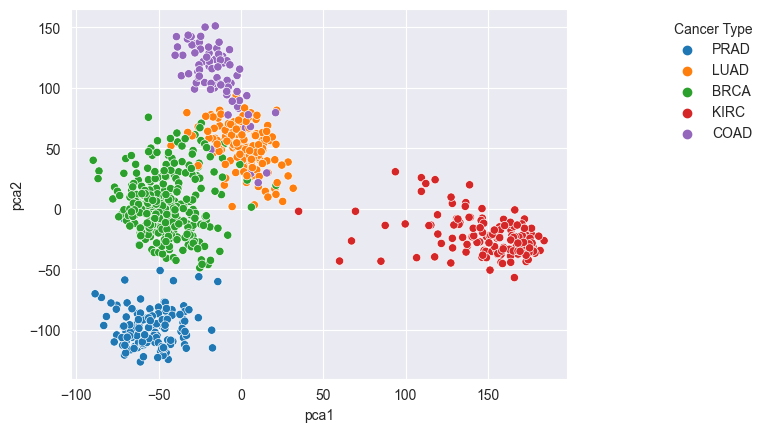

In [6]:
# Present the data on the 5 clusters using seaborn maps 
sns.scatterplot(x='pca1',y='pca2', hue = 'cancer_type',data=data_on_2_components)
# Move the hue legend to the top right corner
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Cancer Type", frameon=False)
plt.show()

In [7]:
# Compute the explained by the two components
explained_variance_ratio = skl_pca_2_components.explained_variance_ratio_
print("Variance explained by first and second component: ", explained_variance_ratio)

# Sum the elements of the array for total variance
var_sum = np.sum(explained_variance_ratio)
print("Total variance explained with 2 components: ", var_sum)

# Same with 80% variance explained: 129 components needed (We omitted plotting, as it is equivalent)
pca_80_varexpl = skl_pca(.80)
df_pca_80 = pd.DataFrame(pca_80_varexpl.fit_transform(df_unlabeled))

explained_variance_ratio2 = pca_80_varexpl.explained_variance_ratio_
var_sum2 = np.sum(explained_variance_ratio2)
print(f"Total variance explained with {df_pca_80.shape[1]} components: ", var_sum2)

Variance explained by first and second component:  [0.1583855 0.1050396]
Total variance explained with 2 components:  0.2634251024443479
Total variance explained with 129 components:  0.8002672762043873


### Results with statsmodels library

In [8]:
# ATTENTION: This takes about 30-60 seconds to run

# check for zero or near-zero variance features (necessary for statsmodels PCA to converge)
variances = np.var(df_unlabeled, axis=0)
near_zero_var_indices = np.where(variances < 1e-6)[0]
if near_zero_var_indices.size > 0:
    print("Features with near-zero variance found. Removing them...")
    stm_data = np.delete(df_unlabeled.values, near_zero_var_indices, axis=1)
print(f"{df_unlabeled.shape[1] - stm_data.shape[1]} features removed. Now {stm_data.shape[1]} features in dataframe.")

# perform PCA with two components. Centered Data works best
stm_pca_2_components = stm_pca(center_data(stm_data), ncomp=2, standardize=False)

# apply components on data
data_on_2_components = pd.DataFrame(stm_pca_2_components.factors)

# add labels
data_on_2_components.columns = ['pca1','pca2']
data_on_2_components['cancer_type'] = df_labeled['Class']
data_on_2_components

Features with near-zero variance found. Removing them...
267 features removed. Now 20264 features in dataframe.


,pca1,pca2,cancer_type
0,-0.029294,0.053922,PRAD
1,-0.001136,-0.051924,LUAD
2,-0.033267,0.004623,PRAD
3,-0.039571,0.041984,PRAD
4,-0.032470,0.005510,BRCA
...,...,...,...
796,-0.028410,0.012770,BRCA
797,-0.006752,-0.030604,LUAD
798,0.004895,-0.012364,COAD
799,-0.025703,0.052961,PRAD


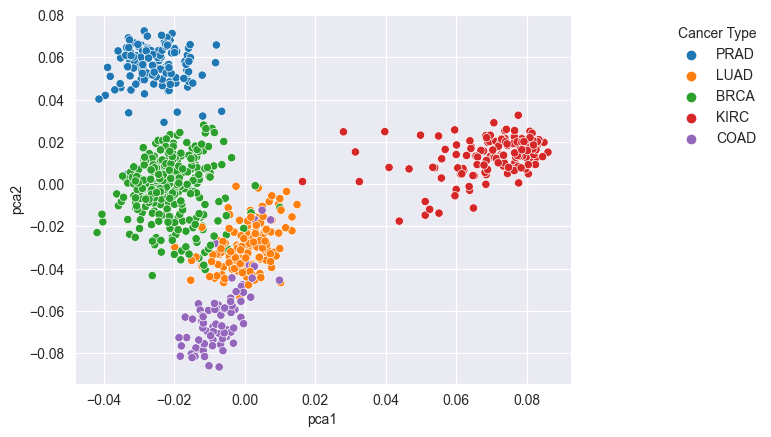

In [9]:
# present the data on the 5 clusters using seaborn maps
sns.scatterplot(x='pca1',y='pca2',hue = 'cancer_type', data=data_on_2_components)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Cancer Type", frameon=False)
plt.show()

## 3. Apply own PCA on data and compare with libraries
You can find our own PCA implementation in the file our_pca.py. Here we apply it to the genetic data.

In [10]:
# Use own pca method on subset of the data (only 2000 columns)
n_components = 2
train = pd.DataFrame(center_data(stm_data)) # we use the stm_data so they can be compared
train = random_sample(train, 801, 2000) 
own_pca = our_pca(train, n_components)
own_eigenvalues, own_eigenvectors = own_pca
own_eigenvectors

array([[ 0.00200794,  0.00154046],
       [-0.00088864,  0.05355257],
       [-0.00993971,  0.00183106],
       ...,
       [ 0.00123157, -0.00448396],
       [-0.00287661, -0.02318141],
       [-0.03087381, -0.03192631]])

In [11]:
# Get the eigenvectors from statsmodels
stm_eigenvectors = stm_pca(train, ncomp=2).eigenvecs

# Check if the eigenvectors contain the same values
check_df = abs(stm_eigenvectors - own_eigenvectors)
print("Differences in eigenvectors: \n", check_df)

# Check if values in the DataFrame are nearly zero
is_close_to_zero = np.isclose(check_df, 0.0, atol=1e-5)
print("Are all eigenvector differences close to zero? ", np.all(is_close_to_zero))

Differences in eigenvectors: 
       eigenvec_0  eigenvec_1
0       0.028257    0.045935
1       0.023368    0.069921
2       0.023279    0.004136
3       0.021061    0.015206
4       0.039192    0.009353
...          ...         ...
1995    0.049368    0.012269
1996    0.027544    0.031426
1997    0.000967    0.002546
1998    0.026803    0.039788
1999    0.065026    0.010049

[2000 rows x 2 columns]
Are all eigenvector differences close to zero?  False


In [12]:
# Get the eigenvectors from sklearn
skl_eigenvectors = skl_pca(n_components=2).fit(train).components_
skl_eigenvectors = np.transpose(skl_eigenvectors)

# Check if the eigenvectors contain the same values
check_df = abs(skl_eigenvectors - own_eigenvectors)
print("Differences in eigenvectors: \n", check_df)

# Check if values in the DataFrame are nearly zero
is_close_to_zero = np.isclose(check_df, 0.0, atol=1e-5)
print("Are all eigenvector differences close to zero? ", np.all(is_close_to_zero))

Differences in eigenvectors: 
 [[4.01588473e-03 9.84512688e-12]
 [1.77727621e-03 4.43646092e-11]
 [1.98794243e-02 5.31916945e-11]
 ...
 [2.46314509e-03 1.02274312e-10]
 [5.75321548e-03 4.45581315e-11]
 [6.17476299e-02 2.40106546e-12]]
Are all eigenvector differences close to zero?  False


In [13]:
# Get the eigenvectors from pca package
pca_eigenvectors = pca_pca(n_components=2).fit_transform(train)['loadings']
pca_eigenvectors = np.transpose(pca_eigenvectors)

# Check if the eigenvectors contain the same values
check_df = abs(pca_eigenvectors - own_eigenvectors)
print("Differences in eigenvectors: \n", check_df)

# Check if values in the DataFrame are nearly zero
is_close_to_zero = np.isclose(check_df, 0.0, atol=1e-5)
print("Are all eigenvector differences close to zero? ", np.all(is_close_to_zero))

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [2000] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]
Differences in eigenvectors: 
             PC1           PC2
14856  0.004016  1.523474e-11
15393  0.001777  1.551324e-10
5829   0.019879  1.053375e-10
7937   0.011759  3.426872e-11
774    0.015349  1.769250e-10
...         ...           ...
7321   0.042267  1.257158e-10
9063   0.005785  8.213467e-11
18855  0.002463  4.073263e-10
5644   0.005753  1.866343e-10
8712   0.061748  2.579610e-10

[2000 rows x 2 columns]
Are all eigenvector differences close to zero?  False


  
Success!
For two out of three libraries, the components are equivalent with ours! (Depends on the sample) Now let's see, how we can apply our components to transform the data set.

[17149, 677, 812, 18312, 5603, 14516, 8476, 5868, 3138, 12029, 1508, 12531, 1650, 5661, 6298, 11268, 453, 18909, 8094, 13134, 665, 10080, 15809, 9934, 20376, 15886, 6614, 11099, 3963, 9779, 16284, 13059, 6724, 54, 13746, 2487, 15882, 13388, 9415, 4561, 17205, 18592, 14768, 1785, 3952, 14058, 8843, 16484, 6728, 3834, 11813, 15470, 16274, 1346, 12057, 15543, 674, 9974, 8625, 3193, 8218, 19219, 18058, 1768, 2726, 11913, 12589, 20429, 14161, 3812, 8536, 989, 19041, 14412, 15122, 11224, 20312, 15993, 19126, 3973, 20071, 13159, 9652, 14230, 4063, 9321, 6608, 15590, 19047, 10770, 6847, 16270, 5211, 11238, 1610, 2571, 19979, 13465, 14228, 198, 17373, 12665, 18883, 2593, 7317, 1676, 11062, 10312, 10130, 2942, 10356, 7452, 7451, 6777, 8126, 13576, 8424, 1411, 12287, 7324, 9519, 9963, 7030, 12612, 13782, 6741, 14636, 14465, 9099, 8458, 485, 15528, 1008, 18664, 13579, 4858, 19040, 17846, 9122, 9557, 5707, 17124, 109, 5671, 7628, 19291, 5765, 3135, 13674, 7737, 16181, 9102, 7246, 2385, 270, 11912, 

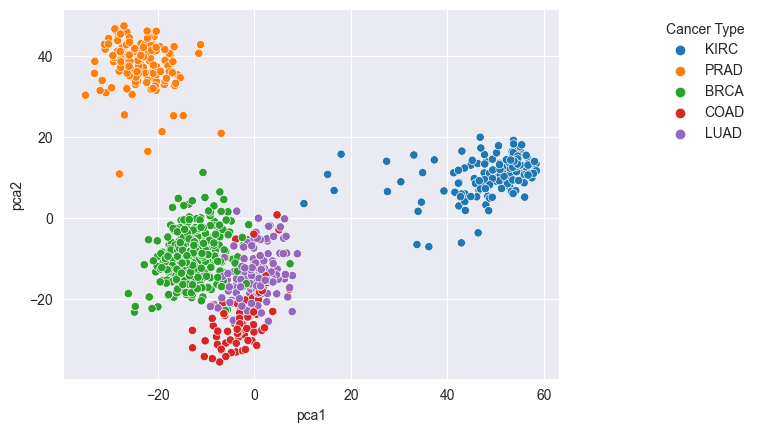

In [14]:
# Get new training sample
data_sample = random_sample(df_labeled, 801, 2000, labeled=True)
Y = pd.DataFrame(data_sample['Class'])
Y.columns = ['Class']
X = center_data(data_sample.drop(['Class'], axis=1))

# Apply our own PCA
eigenvalues, eigenvectors = our_pca(X, 2)
eigenvectors = pd.DataFrame(eigenvectors)
transformed_data = apply_components(X, eigenvectors)
transformed_data = pd.DataFrame(transformed_data)

# Add labels
transformed_data.columns = ['pca1', 'pca2']
transformed_data['cancer_type'] = Y['Class']

# present the data on the 5 clusters using seaborn maps
sns.scatterplot(x='pca1',y='pca2',hue = 'cancer_type', data=transformed_data)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1), title="Cancer Type", frameon=False)
plt.show()

   
## 4. Use results for classification
In this section, we will see, whether our extracted components can be used to classify subjects into different cancer types. First, we will do the classification without dimension reduction.

In [15]:
# initiate classifiers
classifier1 = DecisionTreeClassifier()
classifier2 = DecisionTreeClassifier()
classifier3 = DecisionTreeClassifier()

# Split the transformed data set
X = df_unlabeled
y = df_labeled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree with original data
classifier1.fit(X_train, y_train)
predicted_y = classifier1.predict(X_test)

# Evaluating the accuracy, precision, recall, f1
accuracy = accuracy_score(y_test, predicted_y)
precision = precision_score(y_test, predicted_y, average='macro')
recall = recall_score(y_test, predicted_y, average='macro')
f1 = 2*precision*recall / (precision+recall)
print("Prediction success of the original features without dimension reduction")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Prediction success of the original features without dimension reduction
Accuracy: 0.968944099378882
Precision: 0.9729664324746292
Recall: 0.9727529677784059
F1: 0.9728596884169215


Now, we will see, if the classification works with the data transformed by the library PCA method. 

In [16]:
# Getting subsample from data and defining X and y
y = df_labeled['Class']
X = center_data(df_unlabeled)

# Split the transformed data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate sklearn pca
skl_pca_model = skl_pca(n_components=2)
transformed_data = skl_pca_model.fit_transform(X_train)

# Decision Tree with transformed data
classifier2.fit(transformed_data, y_train)

# predict new data
newdata = X_test.copy()

# transform newdata using fitted pca
newdata_transformed = skl_pca_model.transform(newdata)

# predict labels with trained classifier
predicted_y = classifier2.predict(newdata_transformed)

# Evaluating the accuracy, precision, recall, f1
accuracy = accuracy_score(y_test, predicted_y)
precision = precision_score(y_test, predicted_y, average='macro')
recall = recall_score(y_test, predicted_y, average='macro')
f1 = 2*precision*recall / (precision+recall)
print("Prediction success for all features, transformed with sklearn components:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Prediction success for all features, transformed with sklearn components:
Accuracy: 0.9192546583850931
Precision: 0.9097058823529413
Recall: 0.9174475443088485
F1: 0.9135603125927397


Now, we compare the prediction accuracy with our own implementation. Note that the lower accuracy is mostly due to the reduced feature set.

In [17]:
# Getting sub sample from data and defining X and y
data_sample = random_sample(df_labeled, 801, 2000, labeled=True)
y = data_sample['Class']
X = center_data(data_sample.drop(['Class'], axis=1))

# Split the transformed data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying our own PCA
eigenvalues, eigenvectors = our_pca(X_train, 2)
transformed_data = apply_components(X_train, eigenvectors)

# Fit the data
classifier3.fit(transformed_data, y_train)
# predict test data using fitted pca
newdata_transformed = apply_components(X_test, eigenvectors)
# predict labels with trained classifier
pred_labels = classifier3.predict(newdata_transformed)

# Evaluating the accuracy, precision, recall, f1
accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels, average='macro')
recall = recall_score(y_test, pred_labels, average='macro')
f1 = 2*precision*recall / (precision+recall)
print("Prediction success for only 2000 features, transformed with own components:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

[2940, 14335, 19781, 10295, 13384, 3164, 8923, 19532, 9273, 19046, 13659, 9994, 20116, 3027, 12481, 16784, 16309, 8609, 9663, 16006, 718, 10096, 876, 14790, 11437, 14960, 269, 7431, 13292, 18671, 1928, 8636, 542, 16948, 20326, 5100, 4903, 5512, 18883, 17306, 8820, 1619, 15828, 12524, 15941, 5605, 7307, 16461, 18050, 14201, 8508, 332, 14440, 18349, 20323, 4493, 363, 2211, 2869, 2904, 16802, 18601, 95, 17463, 14242, 9523, 6506, 11933, 4674, 6321, 1484, 950, 14284, 14404, 1324, 17805, 16540, 3478, 17971, 9313, 1155, 17615, 3775, 970, 20470, 15861, 8605, 19749, 5988, 19288, 15529, 1641, 13075, 6627, 8963, 5197, 3487, 434, 14792, 1469, 3892, 11519, 16944, 3583, 7851, 2242, 16443, 4170, 15050, 2392, 10977, 3838, 11315, 11848, 13983, 3323, 8263, 15400, 14604, 13196, 20509, 7832, 9747, 3805, 9644, 3451, 11814, 14066, 17746, 13601, 9336, 19434, 6724, 14249, 13781, 4841, 15981, 10356, 7838, 9948, 15379, 1021, 13764, 16834, 11100, 5749, 5402, 18299, 15157, 13313, 10569, 13180, 5479, 5363, 16528, 

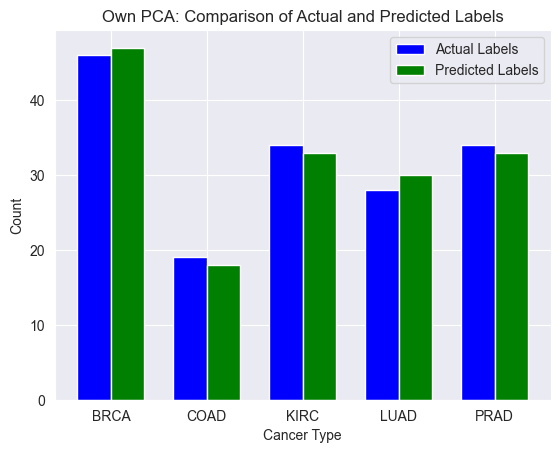

In [18]:
# Occurrences of each cancer type in the actual labels (y_test)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

# Occurrences of each cancer type in the predicted labels (pred_labels)
unique_labels_pred, label_counts_pred = np.unique(pred_labels, return_counts=True)

# Unique cancer types
unique_labels = np.unique(np.concatenate((unique_labels_test, unique_labels_pred)))

bar_width = 0.35

# x-axis positions
index = np.arange(len(unique_labels))

# Plot the bars for actual labels (y_test)
plt.bar(index, label_counts_test, bar_width, label='Actual Labels', color='blue')

# Plot the bars for predicted labels (pred_labels)
plt.bar(index + bar_width, label_counts_pred, bar_width, label='Predicted Labels', color='green')

# Set x-axis labels and tick positions
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Own PCA: Comparison of Actual and Predicted Labels')
plt.xticks(index + bar_width / 2, unique_labels)

plt.legend()
plt.show()

   
## 5. Compare results with tSNE
In this section, we will see, if we PCA was the right technique for us or whether another dimension reduction method (tSNE) would actually perform much better on the dataset.

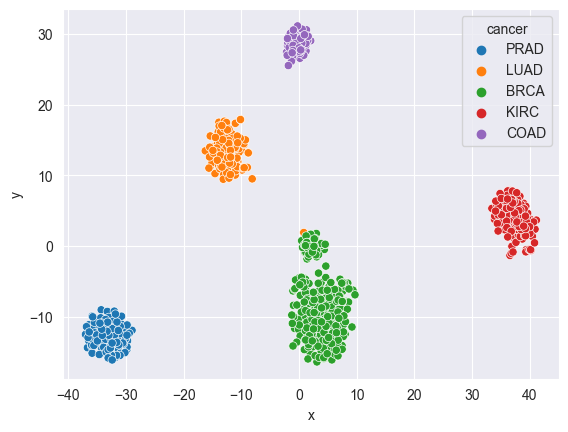

In [19]:
# Initiate t-SNE model
tsne_model = TSNE(learning_rate=200, perplexity=50)
tsne_data = df_unlabeled.copy()

# t-SNE features are computed and a subset is printed
tnse_features = tsne_model.fit_transform(tsne_data)

# Two new columns 'x' and 'y' are added to the dataframe. They correspond to the t-SNE features.
tsne_data['x'] = tnse_features[:,0]
tsne_data['y'] = tnse_features[:,1]

# The 'Class' column is added back to the dataframe under a new name 'cancer'
tsne_data['cancer'] = df_labeled['Class']

# The t-SNE features are plotted again, but this time the points are colored based on the 'cancer' class
sns.scatterplot(x = 'x', y = 'y', hue = 'cancer', data = tsne_data)
plt.show()

Now, we will use the t-SNE features to classify our data.

In [23]:
# Initiate classifier
classifier4 = DecisionTreeClassifier()

# Split the transformed data set
X = df_unlabeled
y = df_labeled['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train new t-SNE model with train/test split
tsne_model = TSNE(learning_rate=200, perplexity=100)
tsne_data = X_train.copy()

# t-SNE features are computed and a subset is printed
tsne_features = tsne_model.fit_transform(tsne_data)

# Decision Tree with data transformed by t-SNE features
classifier4.fit(tsne_features, y_train)

# predict test data using fitted pca
tsne_data_test = X_test.copy()
tsne_features_test = tsne_model.fit_transform(tsne_data_test)

predicted_y = classifier4.predict(tsne_features_test)

# Evaluating the accuracy
accuracy = accuracy_score(y_test, predicted_y)
precision = precision_score(y_test, predicted_y, average='macro')
recall = recall_score(y_test, predicted_y, average='macro')
f1 = 2*precision*recall / (precision+recall)
print("Prediction success of the original number of features, transformed with t-SNE features:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Prediction success of the original number of features, transformed with t-SNE features:
Accuracy: 0.006211180124223602
Precision: 0.002197802197802198
Recall: 0.006896551724137931
F1: 0.0033333333333333335


/Users/sepidehkavianpoor/PycharmProjects/Groupwork/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
